# __APARTADO C__


Antes de empezar vamos a cargar los datos del CSV que nos ha tocado.  
Empezaremos con la carga de las librerias necesarias.

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings("ignore")

In [3]:
DATA_DIR = 'data/insurance.csv'

def read_database(dir : str):
    return pd.read_csv(dir, delimiter= ',')

df = read_database(DATA_DIR)
print(df.head(5))
print(df.describe())
print(df.info())

   age     sex   bmi  children smoker     region  expenses
0   19  female  27.9         0    yes  southwest  16884.92
1   18    male  33.8         1     no  southeast   1725.55
2   28    male  33.0         3     no  southeast   4449.46
3   33    male  22.7         0     no  northwest  21984.47
4   32    male  28.9         0     no  northwest   3866.86
               age          bmi     children      expenses
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.665471     1.094918  13270.422414
std      14.049960     6.098382     1.205493  12110.011240
min      18.000000    16.000000     0.000000   1121.870000
25%      27.000000    26.300000     0.000000   4740.287500
50%      39.000000    30.400000     1.000000   9382.030000
75%      51.000000    34.700000     2.000000  16639.915000
max      64.000000    53.100000     5.000000  63770.430000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Colu

Podemos ver que tenemos 2 columnas decimales que es el bmi y los costes. 2 columnas con valores enteros, age y children. Por ultimo tenemos 3 columnas categoricas smoker, region, sex.

Sabiendo esta informacion vamos a ver la cantidad de gente fumadora.

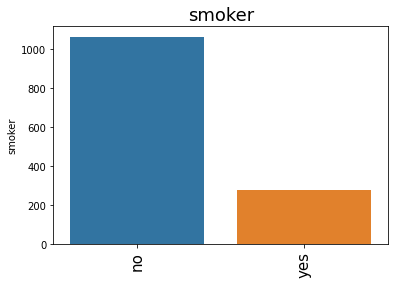

In [4]:
def barplot_gen(df_colum : pd.Series, ax = plt.subplot()):
    classes = df_colum.value_counts()
    class_len = len(classes)
    sns.barplot(x=np.arange(class_len), y=classes, ax = ax)
    ax.set_xticks(np.arange(len(classes)))
    ax.set_xticklabels(classes.index.values.tolist(), rotation=90, fontsize=15)
    ax.set_title(df_colum.name, fontsize=18)

barplot_gen(df['smoker'])

Podemos observar que la cantidad de fumadores en esta base de datos es muy baja, por lo que si queremos realizar una prediccion de esta atributo tendremos problemas para poder realizar un entrenamiento del modelo de red neuronal. Al tratarse en esta practica de utilizar un modelos de regresion lineal y ser valores categoricos, vamos a descartar este valor para realizar la prediccion.

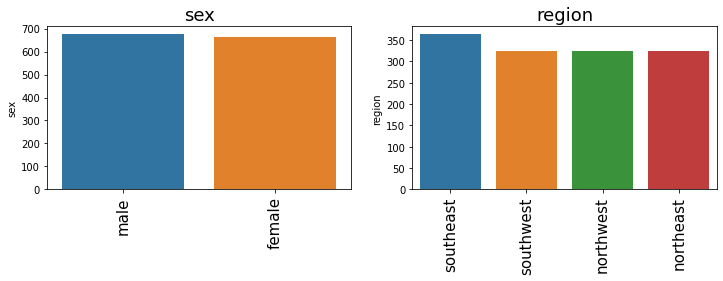

In [5]:
fig, p = plt.subplots(ncols=2, figsize=(12, 3))

barplot_gen(df['sex'], ax = p[0])
barplot_gen(df['region'], ax = p[1])

Una vez visto los valores categoricos podemos descartar smoker como a valor a predecir, ya que tenemos pocos datos de valores de fumadores. Pero en cambio si queremos hacer una regresion logistica podemos utilizar sex.

Ahora vamos a ver los valores no categoricos.

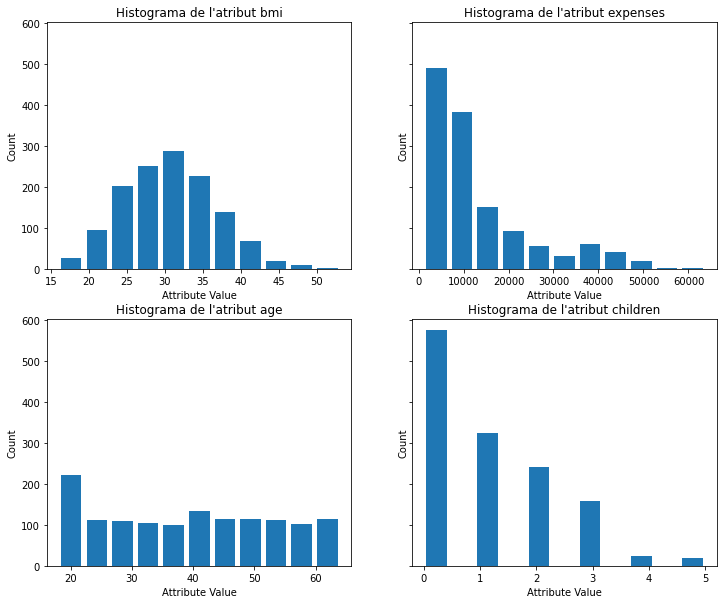

In [6]:
def hist_gen(ax, df_colum : pd.Series):
    ax.set_title(f"Histograma de l'atribut {df_colum.name}")
    ax.set_xlabel("Attribute Value")
    ax.set_ylabel("Count")
    ax.hist(df_colum, bins=11, range=[np.min(df_colum), np.max(df_colum)], histtype="bar", rwidth=0.8)

fig, p = plt.subplots(2, 2, sharey=True, figsize=(12, 10))

hist_gen(p[0,0], df['bmi'])
hist_gen(p[0,1], df['expenses'])
hist_gen(p[1,0], df['age'])
hist_gen(p[1,1], df['children'])

Podemos observar que hay un atributo que si tiene una distribucion Guassiana, en este caso es el atributo bmi.

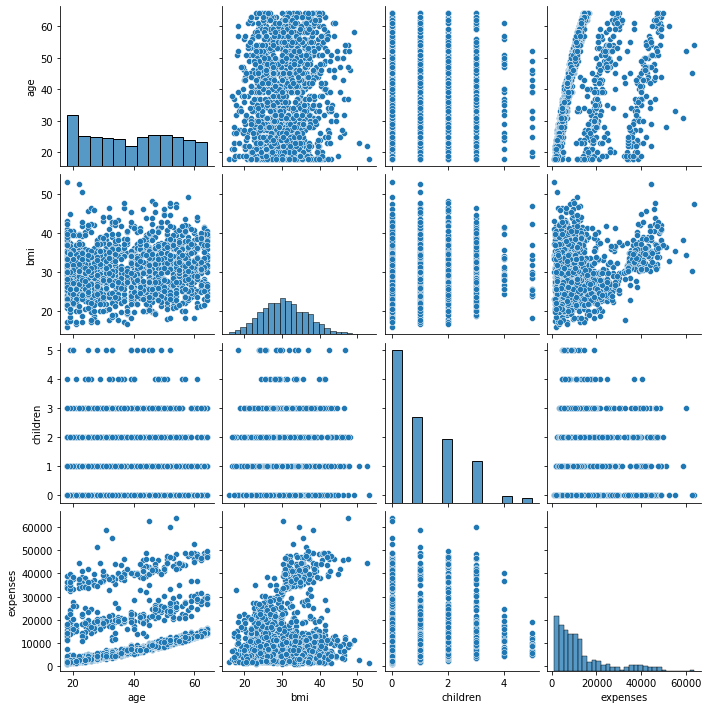

In [7]:
relacio = sns.pairplot(df)

In [8]:
def caregorical_to_onehot_encode(df, col):
    dummy = pd.get_dummies(df[col]) 
    df = df.drop(col, axis = 1) 
    return pd.concat([df, dummy], axis = 1)

def object_to_number(df, column, value):
    df_tmp = df[column].apply(lambda x: 1 if x == value else 0)
    df = df.drop(column, axis = 1) 
    return pd.concat([df, df_tmp], axis = 1)

df = object_to_number(df, 'sex', 'male')
df = object_to_number(df, 'smoker', 'yes')

df = caregorical_to_onehot_encode(df, 'region')

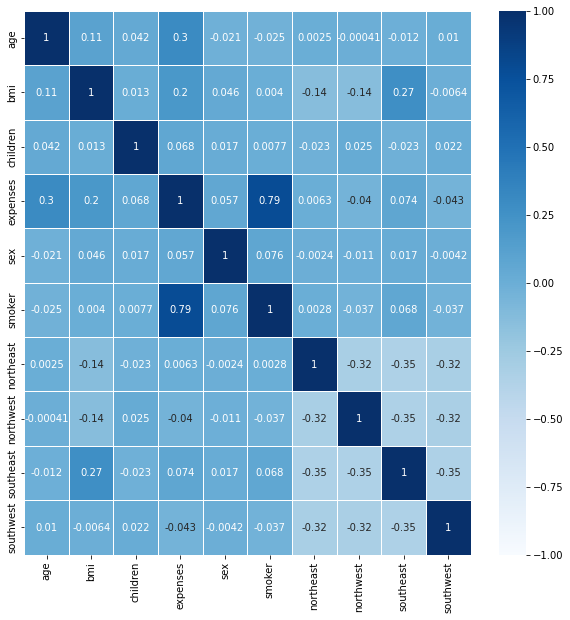

In [9]:
correlacio = df.corr()
plt.figure(figsize=(10, 10))
ax = sns.heatmap(correlacio, annot=True, vmin=-1, linewidths=.5, cmap=plt.cm.Blues)

In [10]:
df.groupby("smoker").expenses.agg(["mean","median","count"])

,mean,median,count
smoker,,,
0,8434.268449,7345.405,1064
1,32050.231971,34456.350,274


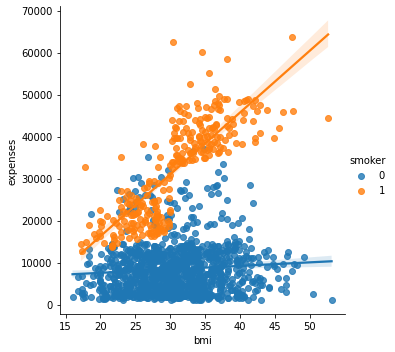

In [11]:
sns.lmplot(x="bmi", y="expenses", hue="smoker", data=df)

Podemos ver como la gente que fuma, cuando mayor es el bmi, mayor es el gasto. En cambio cuando no es fumador, por mucho que aumente su bmi, no aumenta su gasto. Tambine podemos ver las lineas de regrasion que representan como aumentaran el gasto dependiendo de si fuma o no.

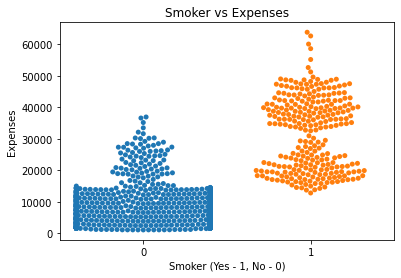

In [12]:
ax = sns.swarmplot(x=df['smoker'], y=df['expenses'])
ax.set_title("Smoker vs Expenses")
plt.xlabel("Smoker (Yes - 1, No - 0)")
plt.ylabel("Expenses")
plt.show(ax)

En esta grafica podemos ver la cantidad de gente fumadora, no fumadora y sus gastos. Se concentra en la parte inferior aquellos que no fuman y los que fuman, se centran mas en la parte superior de la grafica. Esto refuerza la hipotesis de que la mayoria de fumadores gastan mas de los que fuman.

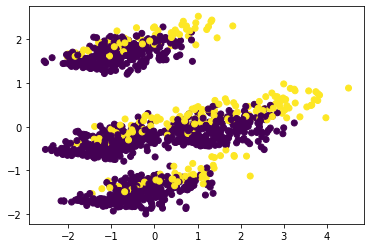

In [13]:
def show_3d_plot(df, column):
    y = df[column].to_numpy()
    X = df.drop([column], axis="columns").to_numpy()
    
    scaler = StandardScaler()
    X_s = scaler.fit_transform(X)

    pca=PCA(n_components=3)
    X_train_3dim = pca.fit_transform(X_s)

    fig = plt.figure()
    ax = Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)
    ax.scatter(X_train_3dim[:,0], X_train_3dim[:,1], X_train_3dim[:,2], c=y)

    plt.show()

def show_2d_plot(df, column):
    y = df[column].to_numpy()
    X = df.drop([column], axis="columns").to_numpy()
    
    scaler = StandardScaler()
    X_s = scaler.fit_transform(X)
    
    pca=PCA(n_components=2)
    X_train_3dim = pca.fit_transform(X_s)

    plt.scatter(X_train_3dim[:,0],X_train_3dim[:,1], c=y)
    plt.show()

show_2d_plot(df, 'smoker')

__1. Quin és el tipus de cada atribut?__  

0.   age  int64
1.   sex  object
2.   bmi  float64
3.   children int64 
4.   smoker  object
5.   region object
6.   expenses float64


__2. Quins atributs tenen una distribució Gaussiana?__  

BMI  

__3. Quin és l'atribut objectiu? Per què?__

Leyendo el extracto de Kaggle y entendiendo el objetivo de la empresa, el cual es otorgar Seguros Médicos. Podemos llegar a suponer que la variable objetivo es la de "expenses", debido a que esta expresa el gasto que tiene cada persona según su actual situación.

# __APARTADO B__


In [145]:
def split_smokers(df, target_column, normalize=True, correlation_min = None):
    
    if correlation_min != None:
        corr = df.corr()
        corr_target = corr[target_column].abs().sort_values(ascending=False)
        corr_target = df[corr_target[corr_target < correlation_min].index].columns
        df_c = df.drop(columns=corr_target)
    else:
        df_c = df
        
    df_yes = df_c[df['smoker'] == 1]
    df_no  = df_c[df['smoker'] == 0]
    
    df_no = df_no.drop(columns=['smoker'])
    df_yes = df_yes.drop(columns=['smoker'])
    
    y_yes = df_yes[target_column].to_numpy().astype('int')
    X_yes = df_yes.drop([target_column], axis="columns").to_numpy()
    
    y_no  = df_no[target_column].to_numpy().astype('int')
    X_no  = df_no.drop([target_column], axis="columns").to_numpy()
    
    if normalize:
        scaler = StandardScaler()
        X_yes = scaler.fit_transform(X_yes)
        X_no = scaler.fit_transform(X_no)
    
    return X_no, y_no, X_yes, y_yes, df_no.columns, df_yes.columns

X_no, y_no, X_yes, y_yes, no_columns, yes_columns = split_smokers(df, 'expenses', False)

Como hemos visto en el apartado anterior, si separamos el el dataset de fumador y no fumador, podemos generar 2 regresiones lineales, una para los que fuman y otra para los que no fuman.

In [171]:
def mse(v1, v2):
    return ((v1 - v2)**2).mean()

def regression(x, y):
    # Creem un objecte de regressió de sklearn
    regr = LinearRegression()

    # Entrenem el model per a predir y a partir de x
    regr.fit(x, y)

    # Retornem el model entrenat
    return regr

def standarize(x_train):
    mean = x_train.mean(0)
    std = x_train.std(0)
    x_t = x_train - mean[None, :]
    x_t /= std[None, :]
    return x_t

def split_data(x, y, train_ratio=0.8):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    n_train = int(np.floor(x.shape[0]*train_ratio))
    indices_train = indices[:n_train]
    indices_test = indices[n_train:] 
    x_train = x[indices_train, :]
    y_train = y[indices_train]
    x_test = x[indices_test, :]
    y_test = y[indices_test]
    return x_train, y_train, x_test, y_test

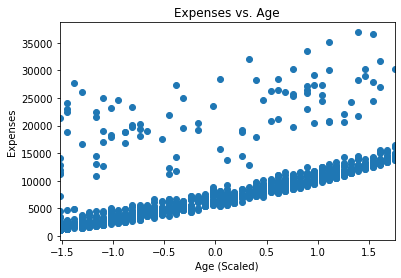

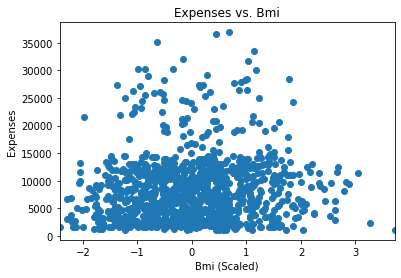

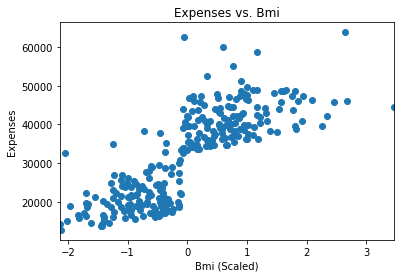

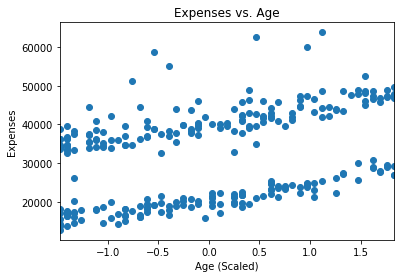


-----------------------
Yes r2 score
-----------------------
Error en atribut 0 age: 127766199.340951
R2 score en atribut 0 age: 0.115129
Error en atribut 1 bmi: 38738628.362017
R2 score en atribut 1 bmi: 0.731708
Error en atribut 2 children: 147335927.330207
R2 score en atribut 2 children: -0.020405
Error en atribut 3 expenses: 140806063.150975
R2 score en atribut 3 expenses: 0.024819
Error en atribut 4 sex: 146136262.628218
R2 score en atribut 4 sex: -0.012096
Error en atribut 5 northeast: 142254028.970696
R2 score en atribut 5 northeast: 0.014791
Error en atribut 6 northwest: 136894729.701176
R2 score en atribut 6 northwest: 0.051908
Error en atribut 7 southeast: 144505447.141567
R2 score en atribut 7 southeast: -0.000802

-----------------------
No r2 score
-----------------------
Error en atribut 0 age: 19079260.800555
R2 score en atribut 0 age: 0.386789
Error en atribut 1 bmi: 31169319.068749
R2 score en atribut 1 bmi: -0.001789
Error en atribut 2 children: 31097856.290510
R2 sc

In [172]:
def show_x_y(x, y, title, x_label, y_label):
    plt.xlim((min(x), max(x)))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.scatter(x, y)
    plt.show()

def calculate_r2_score_atr(X, y, columns):
    x_train, y_train, x_test, y_test = split_data(X, y)
    stndScal = StandardScaler()
    x_train = stndScal.fit_transform(x_train)
    x_test = stndScal.transform(x_test)
    error_np = np.zeros(x_train.shape[1])

    for i in range(x_train.shape[1]):
        x_t = x_train[:,i] # seleccionem atribut i en conjunt de train
        x_v = x_test[:,i] # seleccionem atribut i en conjunt de val.
        x_t = np.reshape(x_t,(x_t.shape[0],1))
        x_v = np.reshape(x_v,(x_v.shape[0],1))

        regr = regression(x_t, y_train)    
        error = mse(y_test, regr.predict(x_v)) # calculem error
        error_np[i] = error
        r2 = r2_score(y_test, regr.predict(x_v))

        print("Error en atribut %i %s: %f" %(i, columns[i], error))
        print("R2 score en atribut %i %s: %f" %(i, columns[i], r2))

show_x_y(X_no[:,0], y_no, "Expenses vs. Age", "Age (Scaled)", "Expenses")
show_x_y(X_no[:,1], y_no, "Expenses vs. Bmi", "Bmi (Scaled)", "Expenses")
show_x_y(X_yes[:,1], y_yes, "Expenses vs. Bmi", "Bmi (Scaled)", "Expenses")
show_x_y(X_yes[:,0], y_yes, "Expenses vs. Age", "Age (Scaled)", "Expenses")

print('\n-----------------------\nYes r2 score\n-----------------------')
calculate_r2_score_atr(X_yes, y_yes, yes_columns)

print('\n-----------------------\nNo r2 score\n-----------------------')
calculate_r2_score_atr(X_no, y_no, no_columns)

__1. Quin són els atributs més importants per fer una bona predicció?__

Los atributos mas importantes para realizar una buena prediccion son aquellos que tienen un R2 score mas priximos a 1.
Amb l'atribut 5, el qual representa si una persona fuma o no.

Així es podrà contestar a aquestes **preguntes**:

__2. Amb quin atribut s'assoleix un MSE menor?__

Al igual que amb el punt anterior la dada que assoleix un MSE menor torna a ser amb Fuma/NoFuma.

__3. Quina correlació hi ha entre els atributs de la vostra base de dades?__


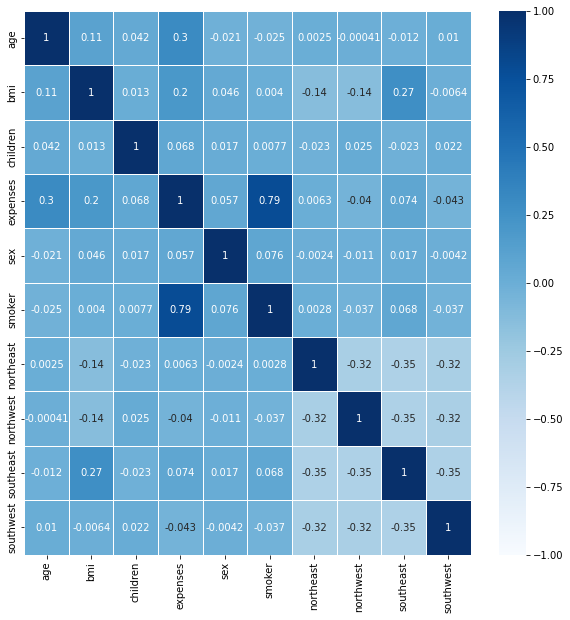

In [173]:
correlacio = df.corr()
plt.figure(figsize=(10, 10))
ax = sns.heatmap(correlacio, annot=True, vmin=-1, linewidths=.5, cmap=plt.cm.Blues)

In [99]:
X_no, y_no, X_yes, y_yes, no_columns, yes_columns = split_smokers(df, 'expenses')
print('\n-----------------------\nYes r2 score (Scaled)\n-----------------------')
calculate_r2_score_atr(X_yes, y_yes, yes_columns)

print('\n-----------------------\nNo r2 score (Scaled)\n-----------------------')
calculate_r2_score_atr(X_no, y_no, no_columns)

X_no, y_no, X_yes, y_yes, no_columns, yes_columns = split_smokers(df, 'expenses', False)
print('\n-----------------------\nYes r2 score\n-----------------------')
calculate_r2_score_atr(X_yes, y_yes, yes_columns)

print('\n-----------------------\nNo r2 score\n-----------------------')
calculate_r2_score_atr(X_no, y_no, no_columns)


-----------------------
Yes r2 score (Scaled)
-----------------------
Error en atribut 0 age: 139423610.749232
R2 score en atribut 0 age: 0.130965
Error en atribut 1 bmi: 39464116.443508
R2 score en atribut 1 bmi: 0.754018
Error en atribut 2 children: 168019816.634773
R2 score en atribut 2 children: -0.047277
Error en atribut 3 expenses: 164569965.522672
R2 score en atribut 3 expenses: -0.025774
Error en atribut 4 sex: 161081401.036499
R2 score en atribut 4 sex: -0.004029
Error en atribut 5 northeast: 165449570.442259
R2 score en atribut 5 northeast: -0.031256
Error en atribut 6 northwest: 156043216.305242
R2 score en atribut 6 northwest: 0.027374
Error en atribut 7 southeast: 166712410.491322
R2 score en atribut 7 southeast: -0.039128

-----------------------
No r2 score (Scaled)
-----------------------
Error en atribut 0 age: 17297532.368592
R2 score en atribut 0 age: 0.362956
Error en atribut 1 bmi: 27114197.514390
R2 score en atribut 1 bmi: 0.001423
Error en atribut 2 children: 27

__4. Com influeix la normalització en la regressió?__

Al aplicar o no la normalització amb el codi de regressió per cada atribut, no veiem cap tipus de diferencia notable. Es pot veure representat a les dades que obtenim, el cual un grup de dades es normalitzat i l'altre no:

    -----------------------
    Yes r2 score (Scaled)
    -----------------------
    Error en atribut 0 age: 139423610.749232
    R2 score en atribut 0 age: 0.130965
    Error en atribut 1 bmi: 39464116.443508
    R2 score en atribut 1 bmi: 0.754018
    Error en atribut 2 children: 168019816.634773
    R2 score en atribut 2 children: -0.047277
    Error en atribut 3 expenses: 164569965.522672
    R2 score en atribut 3 expenses: -0.025774
    Error en atribut 4 sex: 161081401.036499
    R2 score en atribut 4 sex: -0.004029
    Error en atribut 5 northeast: 165449570.442259
    R2 score en atribut 5 northeast: -0.031256
    Error en atribut 6 northwest: 156043216.305242
    R2 score en atribut 6 northwest: 0.027374
    Error en atribut 7 southeast: 166712410.491322
    R2 score en atribut 7 southeast: -0.039128

    -----------------------
    No r2 score (Scaled)
    -----------------------
    Error en atribut 0 age: 17297532.368592
    R2 score en atribut 0 age: 0.362956
    Error en atribut 1 bmi: 27114197.514390
    R2 score en atribut 1 bmi: 0.001423
    Error en atribut 2 children: 27606240.643686
    R2 score en atribut 2 children: -0.016699
    Error en atribut 3 expenses: 27735564.150629
    R2 score en atribut 3 expenses: -0.021461
    Error en atribut 4 sex: 27628602.015564
    R2 score en atribut 4 sex: -0.017522
    Error en atribut 5 northeast: 27446670.480679
    R2 score en atribut 5 northeast: -0.010822
    Error en atribut 6 northwest: 27582042.787077
    R2 score en atribut 6 northwest: -0.015807
    Error en atribut 7 southeast: 27476011.866666
    R2 score en atribut 7 southeast: -0.011903

    -----------------------
    Yes r2 score
    -----------------------
    Error en atribut 0 age: 132533687.792155
    R2 score en atribut 0 age: 0.008680
    Error en atribut 1 bmi: 55076980.440049
    R2 score en atribut 1 bmi: 0.588038
    Error en atribut 2 children: 137947547.975719
    R2 score en atribut 2 children: -0.031814
    Error en atribut 3 expenses: 141721364.266430
    R2 score en atribut 3 expenses: -0.060041
    Error en atribut 4 sex: 141732781.547119
    R2 score en atribut 4 sex: -0.060127
    Error en atribut 5 northeast: 146146306.677267
    R2 score en atribut 5 northeast: -0.093139
    Error en atribut 6 northwest: 138314088.391186
    R2 score en atribut 6 northwest: -0.034556
    Error en atribut 7 southeast: 142827445.320557
    R2 score en atribut 7 southeast: -0.068314

    -----------------------
    No r2 score
    -----------------------
    Error en atribut 0 age: 19761133.268150
    R2 score en atribut 0 age: 0.309007
    Error en atribut 1 bmi: 28806225.262765
    R2 score en atribut 1 bmi: -0.007276
    Error en atribut 2 children: 28069688.356532
    R2 score en atribut 2 children: 0.018479
    Error en atribut 3 expenses: 28491406.710602
    R2 score en atribut 3 expenses: 0.003733
    Error en atribut 4 sex: 28766962.281738
    R2 score en atribut 4 sex: -0.005903
    Error en atribut 5 northeast: 28867266.039021
    R2 score en atribut 5 northeast: -0.009410
    Error en atribut 6 northwest: 29568413.642810
    R2 score en atribut 6 northwest: -0.033927
    Error en atribut 7 southeast: 28622677.691249
    R2 score en atribut 7 southeast: -0.000858


__5. Com millora la regressió quan es filtren aquells atributs de les mostres que no contenen informació?__

L'error R2 millora molt, ja que només utilitzem els atributs que superen un desitjat threshold, com per exemple "fuma", que ens dona un R2 superior a 0.5.

In [153]:
def error_r2(X, y):
    x_train, y_train, x_test, y_test = split_data(X, y)
    print(x_train.shape)

    regr = regression(x_train, y_train)
    error = mse(y_test, regr.predict(x_test))
    r2 = r2_score(y_test, regr.predict(x_test))

    print("Error: ", error, " R2: ", r2)
    

print('No Filter')

X_no, y_no, X_yes, y_yes, no_columns, yes_columns = split_smokers(df, 'expenses', True, None)

print('Yes smoke r2 score')
error_r2(X_no, y_no)
print('No smoke r2 score')
error_r2(X_yes, y_yes)

print('Filter')

X_no, y_no, X_yes, y_yes, no_columns, yes_columns = split_smokers(df, 'expenses', True, 0.1)

print('Yes smoke r2 score')
error_r2(X_no, y_no)
print('No smoke r2 score')
error_r2(X_yes, y_yes)

No Filter
Yes smoke r2 score
(851, 8)
Error:  17991709.36618042  R2:  0.43013825881265455
No smoke r2 score
(219, 8)
Error:  31256458.012452453  R2:  0.7348128222568906
Filter
Yes smoke r2 score
(851, 2)
Error:  25739825.95956485  R2:  0.3778368234312818
No smoke r2 score
(219, 2)
Error:  32793953.119723886  R2:  0.8056667827608712


__6. Si s'aplica un PCA, a quants components es redueix l'espai? Per què?__

Es redueix a tants com es refereixi al parametre n_components de PCA(). Però també podem trobar variables que podem assignar al parametre n_components, com per exemple 'mle', el qual destria els atributs més significatius. El perquè tria el número que tria al valor 'mle' ho hem trobat a un 'paper'. <ins> https://tminka.github.io/papers/pca/minka-pca.pdf </ins>

Para ver la dimensionalidad que necesitamos para uestra regresion, vamos a buscar el error medio mas pequeño que obtenemos por cada dimensión.

In [19]:
X_no, y_no, X_yes, y_yes, no_columns, yes_columns = split_smokers(df, 'expenses', True, None)

def best_dimension_pca(X, y):
    pca=PCA(n_components='mle', svd_solver='full')

    x_train_n_dim = pca.fit_transform(X_s)
    x_train_n_dim = pca.fit_transform(X_t)

    print("Shape: ", X_train_3dim.shape)
    print("Shape: ", X_train_3dim_t.shape)

(1338, 9)
Shape:  (1338, 8)
Shape:  (1070, 8)


Original Dimension: 9
Dimension:  1  R2:  -19.4240286159994
Dimension:  2  R2:  -18.945632114498846
Dimension:  3  R2:  -17.945837513078835
Dimension:  4  R2:  -2.6514075530368038
Dimension:  5  R2:  -0.9414802543614709
Dimension:  6  R2:  -0.8597160384604308
Dimension:  7  R2:  0.5740450512661335
Dimension:  8  R2:  0.6346826341303009
Dimension:  9  R2:  0.6346826341303005
La mejor dimension es (8, 0.6346826341303009)


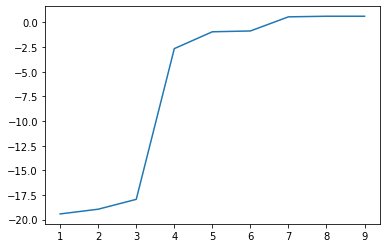

In [184]:
def split_x_y_scale(df, y_target):
    y = df[y_target].to_numpy().astype('int')
    X = df.drop([y_target], axis="columns").to_numpy()
    scaler = StandardScaler()
    X_s = scaler.fit_transform(X)
    
    return X_s, y

X, y = split_x_y_scale(df, 'expenses')

def calculate_best_dimension_pca(X, y):
    print(f'Original Dimension: {X.shape[1]}')
    x_train, y_train, x_test, y_test = split_data(X, y)
    results = []
    for d in range(1, x_train.shape[1] + 1):
        pca=PCA(n_components=d)
        x_train_d = pca.fit_transform(x_train)
        x_test_d = pca.transform(x_test)
        reg = regression(x_train_d, y_train)
        results.append((d, r2_score(reg.predict(x_test_d), y_test)))
        print("Dimension: ", d, " R2: ", r2_score(reg.predict(x_test_d), y_test))
    return results

results = calculate_best_dimension_pca(X, y)
plt.plot([x[0] for x in results], [x[1] for x in results])
print(f'La mejor dimension es {max(results, key = lambda x: x[1])}')

Podemos observar que el algotimo de mle, tambien escoge el numero de dimensionalidad que minimiza el error medio.

In [21]:
y = df['expenses'].to_numpy().astype('int')
X = df.drop(['expenses'], axis="columns").to_numpy()

scaler = StandardScaler()
X_s = scaler.fit_transform(X)

# PCA no presenta variabilitat al resultat
pca=PCA(n_components='mle', svd_solver='full')
X_train_3dim = pca.fit_transform(X_s)

# Dividim dades d'entrenament
x_train, y_train, x_test, y_test = split_data(X_s, y)

regr = regression(x_train, y_train)    
error = mse(y_test, regr.predict(x_test)) # calculem error
r2 = r2_score(y_test, regr.predict(x_test))

print("error: ", error, "\nR2: ", r2, "\nx3: ", X_train_3dim.shape)

error:  35506009.97093656 
R2:  0.744721367188047 
x3:  (1338, 8)


# APARTADO A

In [60]:
df = read_database(DATA_DIR)
df = object_to_number(df, 'sex', 'male')
df = object_to_number(df, 'smoker', 'yes')
df = caregorical_to_onehot_encode(df, 'region')

def get_column_most_correlation(df, target_column):
    '''
        Get the column with the highest correlation with the target column
    '''
    corr = df.corr()
    corr_target = corr[target_column].abs().sort_values(ascending=False)
    corr_target = df[corr_target[corr_target < 0.15].index].columns
    corr_target = df.drop(columns=corr_target)
    
    corr_target_yes = corr_target[corr_target['smoker'] == 1]
    corr_target_no  = corr_target[corr_target['smoker'] == 0]
    
    corr_target_no = corr_target_no.drop(columns=['smoker'])
    corr_target_yes = corr_target_yes.drop(columns=['smoker'])
    
    y_yes = corr_target_yes['expenses'].to_numpy().astype('int')
    X_yes = corr_target_yes.drop(['expenses'], axis="columns").to_numpy()
    
    y_no  = corr_target_no['expenses'].to_numpy().astype('int')
    X_no  = corr_target_no.drop(['expenses'], axis="columns").to_numpy()
    
    scaler = StandardScaler()
    X_no = scaler.fit_transform(X_no)
    
    scaler = StandardScaler()
    X_yes = scaler.fit_transform(X_yes)
    
    return X_no, y_no, X_yes, y_yes

X_no, y_no, X_yes, y_yes = get_column_most_correlation(df, 'expenses')

x_train_no, y_train_no, x_test_no, y_test_no = split_data(X_no, y_no)
x_train_yes, y_train_yes, x_test_yes, y_test_yes = split_data(X_yes, y_yes)

print(x_train_no)

[[-0.24049078 -0.27371136]
 [ 0.75405411  0.25609674]
 [-1.51919137 -0.38960689]
 ...
 [-0.45360755 -0.05847682]
 [-0.80880216 -1.13464953]
 [ 1.18028764  0.23954024]]


In [304]:

class Regression():

    def __init__(self, X, y, lr = 0.01, regulador = 0.001) -> None:
        self.X = X
        if X[:,0].max() == 1 and X[:,0].min():
            X[:,0] = 0
        self.y = y
        self.lr = lr
        self.regulador = regulador
        self.b = 0
        self.w = np.zeros(X.shape[1])
        self.mse = []
    
    def predict(self, X):
        return (X @ self.w) + self.b

    def hipotesis(self):
        return (self.X @ self.w) + self.b

    def mse_lambda(self):
        return (1/(2 * self.X.shape[0])) * np.sum((self.hipotesis() - self.y)**2) + (self.regulador * np.sum(self.w**2))

    def train(self, max_iter = 10000, epsilon = 0.1):
        self.mse = [np.Inf]
        m = self.X.shape[0]
        
        for _ in range(max_iter):
            prediccion = self.hipotesis()
            for j in range(self.w.shape[0]):
                final = (self.regulador/m) * self.w[j]
                otro = np.sum(((prediccion - self.y) * self.X[:,j]))/m
                self.w[j] = self.w[j] - self.lr * (otro - final)
            self.b = self.b - (self.lr * (2/m)) * np.sum(prediccion - self.y)
            self.mse.append(self.mse_lambda())
            if abs(self.mse[-1] - self.mse[-2]) < epsilon:
                break

lr: 1e-08 l: 1e-08 epsilon: 1 iters: 2001 mse: 52365113.38904713
(1e-08, 1e-08, 1, 2001, 52365113.38904713)
lr: 1e-07 l: 1e-08 epsilon: 1 iters: 2001 mse: 52323646.08750652
(1e-07, 1e-08, 1, 2001, 52323646.08750652)
lr: 1e-06 l: 1e-08 epsilon: 1 iters: 2001 mse: 51911508.701347366
(1e-06, 1e-08, 1, 2001, 51911508.701347366)
lr: 9.999999999999999e-06 l: 1e-08 epsilon: 1 iters: 2001 mse: 48033174.20246858
(9.999999999999999e-06, 1e-08, 1, 2001, 48033174.20246858)
lr: 9.999999999999999e-05 l: 1e-08 epsilon: 1 iters: 2001 mse: 25734515.11114949
(9.999999999999999e-05, 1e-08, 1, 2001, 25734515.11114949)
lr: 0.001 l: 1e-08 epsilon: 1 iters: 2001 mse: 10623911.93949726
(0.001, 1e-08, 1, 2001, 10623911.93949726)
lr: 0.01 l: 1e-08 epsilon: 1 iters: 1139 mse: 10037578.374213876
(0.01, 1e-08, 1, 1139, 10037578.374213876)
lr: 0.1 l: 1e-08 epsilon: 1 iters: 139 mse: 10037477.17270739
(0.1, 1e-08, 1, 139, 10037477.17270739)
lr: 1.0 l: 1e-08 epsilon: 1 iters: 2001 mse: nan
(0.1, 1e-08, 1, 139, 100374

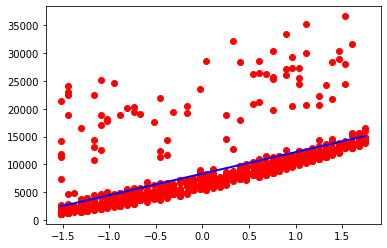

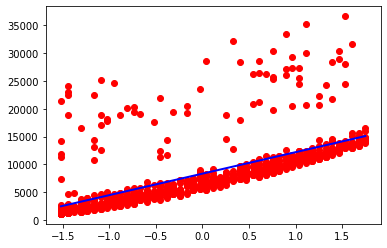

In [324]:
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=2)

def show_polinomial(X, y, coefs, bias):
    plt.scatter(X, y_train_no, color='red')
    X_seq = np.linspace(X.min(),X.max(),300).reshape(-1,1)
    plt.plot(X_seq, np.polyval(coefs, X_seq) + bias, color='blue', linewidth=2)
    plt.show()

tests = []

dummy = x_train_no[:,0].reshape(x_train_no.shape[0], 1)
X_poly = poly_reg.fit_transform(dummy)

epsilon = 1
for _ in range(10):
    l = 0.00000001
    for _ in range(10):
        lr = 0.00000001
        for _ in range(10):
            reg = Regression(X_poly, y_train_no, lr, l)
            reg.train(2000, epsilon)
            print(f'lr: {lr} l: {l} epsilon: {epsilon} iters: {len(reg.mse)} mse: {reg.mse[-1]}')
            tests.append((lr, l, epsilon ,len(reg.mse), reg.mse[-1]))
            lr *= 10
            print(min(tests, key=lambda x: x[4]))
        l *= 10
    epsilon /= 10

(0.1, 0.001, 0.001, 249, 10052562.501838088)
        
print(tests)
print(min(tests, key=lambda x: x[4]))

dummy = x_train_no[:,0].reshape(x_train_no.shape[0], 1)
X_poly = poly_reg.fit_transform(dummy)
reg = Regression(X_poly, y_train_no, 0.1, 1)
reg.train()

r = regression(X_poly, y_train_no)

print(reg.w, reg.b)
print(r.coef_, r.intercept_)

show_polinomial(dummy, y_train_no, reg.w, reg.b)
show_polinomial(dummy, y_train_no, r.coef_, r.intercept_)

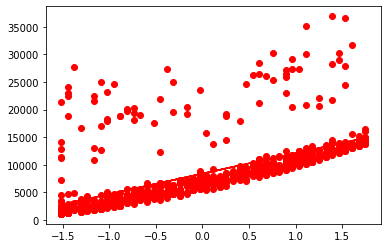

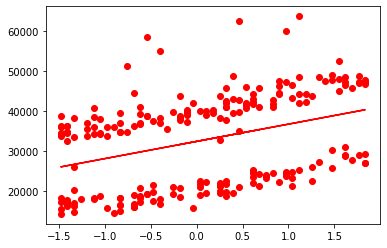

In [24]:

atribut1 = x_train_no[:,0].reshape(x_train_no.shape[0], 1) 
r = regression(atribut1, y_train_no)
predicted = r.predict(atribut1)
plt.figure()

ax = plt.scatter(x_train_no[:,0], y_train_no, color='red')
plt.plot(atribut1, predicted, 'r')

atribut1 = x_train_yes[:,0].reshape(x_train_yes.shape[0], 1) 
r = regression(atribut1, y_train_yes)
predicted = r.predict(atribut1)
plt.figure()

ax = plt.scatter(x_train_yes[:,0], y_train_yes, color='red')
plt.plot(atribut1, predicted, 'r')


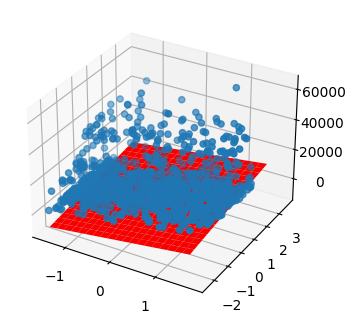

In [339]:
# Creem figura 3d
from mpl_toolkits.mplot3d import axes3d, Axes3D
# generem dades 3D d'exemple
x_val = x_train
y_val = y_train

regr = Regression(x_val, y_val)
regr.train()
predX3D = regr.predict(x_val)

# Afegim els 1's
A = np.hstack((x_val,np.ones([x_val.shape[0],1])))
w = np.linalg.lstsq(A,predX3D)[0]

#Dibuixem
#1r creem una malla acoplada a la zona de punts per tal de representar el pla
malla = (range(20) + 0 * np.ones(20)) / 10 
malla_x1 =  malla * (max(x_val[:,0]) - min(x_val[:,0]))/2 + min(x_val[:,0])
malla_x2 =  malla * (max(x_val[:,1]) - min(x_val[:,1]))/2 + min(x_val[:,1])

#la funcio meshgrid ens aparella un de malla_x1 amb un de malla_x2, per atot
#element de mallax_1 i per a tot element de malla_x2.
xplot, yplot = np.meshgrid(malla_x1 ,malla_x2)

# Cal desnormalitzar les dades
def desnormalitzar(x, mean, std):
    return x * std + mean

#ara creem la superficies que es un pla
zplot = w[0] * xplot + w[1] * yplot + w[2]

#Dibuixem punts i superficie
plt3d = plt.figure('Coeficiente prismatico -- Relacio longitud desplacament 3D', dpi=100.0).gca(projection='3d')
plt3d.plot_surface(xplot,yplot,zplot, color='red')
plt3d.scatter(x_val[:,0],x_val[:,1],y_val)

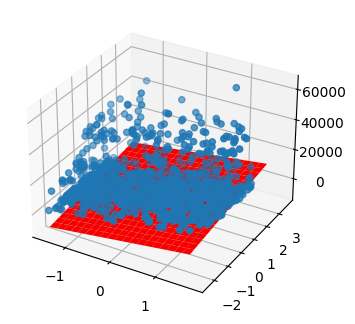

In [340]:
# generem dades 3D d'exemple
x_val = x_train
y_val = y_train
regr = regression(x_val, y_val)
predX3D = regr.predict(x_val)

# Afegim els 1's
A = np.hstack((x_val,np.ones([x_val.shape[0],1])))
w = np.linalg.lstsq(A,predX3D)[0]

#Dibuixem
#1r creem una malla acoplada a la zona de punts per tal de representar el pla
malla = (range(20) + 0 * np.ones(20)) / 10 
malla_x1 =  malla * (max(x_val[:,0]) - min(x_val[:,0]))/2 + min(x_val[:,0])
malla_x2 =  malla * (max(x_val[:,1]) - min(x_val[:,1]))/2 + min(x_val[:,1])

#la funcio meshgrid ens aparella un de malla_x1 amb un de malla_x2, per atot
#element de mallax_1 i per a tot element de malla_x2.
xplot, yplot = np.meshgrid(malla_x1 ,malla_x2)

# Cal desnormalitzar les dades
def desnormalitzar(x, mean, std):
    return x * std + mean

#ara creem la superficies que es un pla
zplot = w[0] * xplot + w[1] * yplot + w[2]

#Dibuixem punts i superficie
plt3d = plt.figure('Coeficiente prismatico -- Relacio longitud desplacament 3D', dpi=100.0).gca(projection='3d')
plt3d.plot_surface(xplot,yplot,zplot, color='red')
plt3d.scatter(x_val[:,0],x_val[:,1],y_val)

Així es podrà contestar a aquestes preguntes:

1. Com influeixen tots els paràmetres en el procés de descens? Quins valors de learning rate convergeixen més ràpid a la solució òptima? Com influeix la inicialització del model en el resultat final? 

Los paremetros de nuestro modelos son:  

learning-rate -> Es el porcentaje de cambio con el que se actualizan los pesos en cada iteración, en otras palabras, cada vez que se realiza una iteración en el proceso de entrenamiento se deben actualizar los pesos de la entrada para poder dar cada vez una mejor aproximación.  

max_iter -> Numero maximo de iteraciones que se realiza.

epsilon -> Valor que marca cuando los pesos del modelos han acabado de converger.

Con un learning-rate alto el modelo va a converg

2. Quines funcions polinomials (de diferent grau, de diferents combinacions d'atributs, ...) heu escollit per ser apreses amb el vostre descens del gradient? quina ha donat el millor resultat (en error i rapidesa en convergència)?

3. Utilitzeu el regularitzador en la fòrmula de funció de cost i descens del gradient i proveu polinomis de diferent grau. Com afecta el valor del regularitzador?

3. Quina diferència (quantitativa i qualitativa) hi ha entre el vostre regressor i el de la llibreria ?

4. Té sentit el model (polinomial) trobat quan es visualitza sobre les dades? 

5. Ajuda la visualització a identificar aquelles mostres per a les que el regressor obté els pitjors resultats de predicció? 
